In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

In [3]:
import os
data_path = '/home/zelig/Documents/dataQuest/misc/MLPB/Problems/Classify Dart Throwers/_Data'
os.chdir(data_path)

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

dtrain = train[['XCoord', 'YCoord']]
y_train = train['Competitor']
dtest = test[['XCoord', 'YCoord']]
y_test = test['Competitor']

dtrain = dtrain.assign(distFromOrg = np.sqrt(np.square(dtrain['XCoord'])+np.square(dtrain['YCoord'])))
dtest = dtest.assign(distFromOrg = np.sqrt(np.square(dtest['XCoord'])+np.square(dtest['YCoord'])))

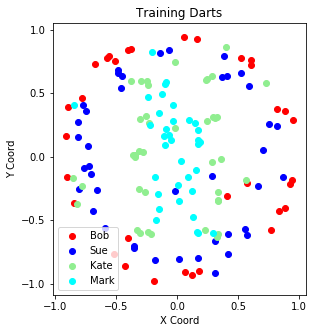

In [5]:
colors = ('red', 'blue', 'lightgreen', 'cyan')
throwers = y_train.unique()
fig = plt.figure(figsize=(10,5))
fig.add_axes()
ax = fig.add_subplot(121)
for col,thr in zip(colors,throwers):    
    ax.scatter(dtrain.loc[y_train==thr,'XCoord'],dtrain.loc[y_train==thr,'YCoord'],c=col,label=thr)
    ax.set(title='Training Darts', xlabel='X Coord',ylabel='Y Coord')
    ax.set_yticks(np.arange(-1,1.5,0.5))
    ax.legend(loc='best')   

# K-Nearest Neighbors (Base Model1)

In [6]:
pipe = Pipeline([['sc',StandardScaler()] , ['knn', KNeighborsClassifier()]])
params = {'knn__n_neighbors':range(1,30)}
grid = GridSearchCV(estimator=pipe, param_grid=params, cv=5)
grid.fit(dtrain,y_train)
clf1 = grid.best_estimator_

In [7]:
y_pred = clf1.predict(dtest)
accuracy_score(y_test,y_pred)

0.72972972972972971

In [ ]:
fails = np.extract(y_test!=y_pred,y_test)
val, count = np.unique(fails,return_counts=True)
print(np.asarray((val,count)).T)

In [ ]:
y_test.value_counts()

In [ ]:
val, count = np.unique(y_pred,return_counts=True)
print(np.asarray((val,count)).T)

# Support Vector Machine (Base Model2)

In [8]:
pipe = Pipeline([['sc',StandardScaler()] , ['svm', LinearSVC(dual=False)]])

params = {'svm__C':[0.001,0.01,0.1,1,10,100,1000], 
          'svm__penalty':['l1', 'l2'], 
          'svm__multi_class':['ovr', 'crammer_singer']}
grid = GridSearchCV(estimator=pipe, param_grid=params, cv=5)
grid.fit(dtrain,y_train)
clf2 = grid.best_estimator_

In [9]:
y_pred = clf2.predict(dtest)
accuracy_score(y_test,y_pred)

0.83783783783783783

In [ ]:
fails = np.extract(y_test!=y_pred,y_test)
val, count = np.unique(fails,return_counts=True)
print(np.asarray((val,count)).T)

In [ ]:
y_test.value_counts()

In [ ]:
val, count = np.unique(y_pred,return_counts=True)
print(np.asarray((val,count)).T)

# Stacking (Meta Ensembling)

#### 1. Partition the training data into test folds

In [10]:
splitter = StratifiedKFold(n_splits=5, shuffle=True)
kfolds = splitter.split(dtrain,y_train)

kfolds = [fold for _,fold in kfolds]

#### 2. Create a dataset called train_meta with the same row Ids and fold Ids as the training dataset. Similarly create a dataset called test_meta with the same row Ids as the test dataset and columns M1 and M2. For each base model:
#### 2.1 Fit the model to the training fold and make predictions on the test fold. Store these predictions in train_meta to be used as features for the stacking model.  
#### 2.2 Fit each base model to the full training dataset and make predictions on the test dataset. Store these predictions inside test_metal.

In [11]:
def get_train_meta(clf,kfolds):
    meta = pd.Series(index=dtrain.index)
    for test_fold in kfolds:
        train_fold = ~dtrain.index.isin(test_fold)
        clf.fit(dtrain.ix[train_fold], y_train.ix[train_fold])
        meta.ix[test_fold] = clf.predict(dtrain.ix[test_fold])
    return meta

In [12]:
def get_test_meta(clf):
    return pd.Series(clf.predict(dtest))

In [13]:
params = clf1.get_params()['steps'][1][1].get_params()
clf = KNeighborsClassifier().set_params(**params)
train_meta_clf1 = get_train_meta(clf,kfolds)
test_meta_clf1 = get_test_meta(clf1)

params = clf2.get_params()['steps'][1][1].get_params()
clf = LinearSVC(dual=False).set_params(**params)
train_meta_clf2 = get_train_meta(clf,kfolds)
test_meta_clf2 = get_test_meta(clf2)

In [14]:
sc = StandardScaler()
dtrain_std = pd.DataFrame(sc.fit_transform(dtrain))
dtest_std = pd.DataFrame(sc.fit_transform(dtest))

In [15]:
train_meta = dtrain_std.assign(meta_clf1=train_meta_clf1).assign(meta_clf2=train_meta_clf2)
test_meta = dtest_std.assign(meta_clf1=test_meta_clf1).assign(meta_clf2=test_meta_clf2)

In [16]:
X_train = pd.get_dummies(train_meta)

In [ ]:
X_train.head()

#### 3. Fit a new model, S (i.e the stacking model) to train_meta, using M1 and M2 as features. Optionally, include other features from the original training dataset or engineered features

In [17]:
X_train = pd.get_dummies(train_meta)
lr = LogisticRegression()
params = {'C':[.001, .01, .1, 1, 10, 100], 'penalty':['l1', 'l2']}

grid = GridSearchCV(estimator=lr, param_grid=params, cv=5)
grid.fit(X_train,y_train)
clf = grid.best_estimator_

In [ ]:
clf.get_params()

In [ ]:
grid.cv_results_

#### 4. Use the stacked model S to make final predictions on test_meta

In [18]:
X_test = pd.get_dummies(test_meta)

In [19]:
blind_spots = [c for c in X_train.columns if c not in X_test.columns]

In [20]:
for att in blind_spots:
    X_test[att] = np.zeros(len(X_test), dtype=int)

In [ ]:
X_test.head()

In [21]:
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7567567567567568